In [8]:
import torch
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
from main import Generator3D, generate_noise, upsample_3d

output_dir = "output_HJ"
device = torch.device(f"cuda:0")
model_path = os.path.join(output_dir, 'trained_model_3d.pth')

saved_data = torch.load(model_path, map_location=device)
trained_generators_state_dicts = saved_data['generators_state_dicts']
fixed_noise_maps = saved_data['fixed_noise_maps']
pyramid_shapes = saved_data['pyramid_shapes']
train_opt_dict = saved_data['opt']
pyramid = saved_data['pyramid']

original = np.load('single_channel_3d.npy')
original.shape

# Create dummy pyramid for shape info if needed, or use saved shapes
# This part might need refinement depending on how gen_size interacts
class DummyOpt: pass
train_opt = DummyOpt()
for k, v in train_opt_dict.items(): 
    setattr(train_opt, k, v)
train_opt.nc_im = 1 # Assume single channel if not saved explicitly


C:\Users\DELL\AppData\Local\Temp\ipykernel_37556\4148303989.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_data = torch.load(model_path, map_location=device)


In [9]:
pyramid[0].shape

torch.Size([1, 1, 6, 11, 11])

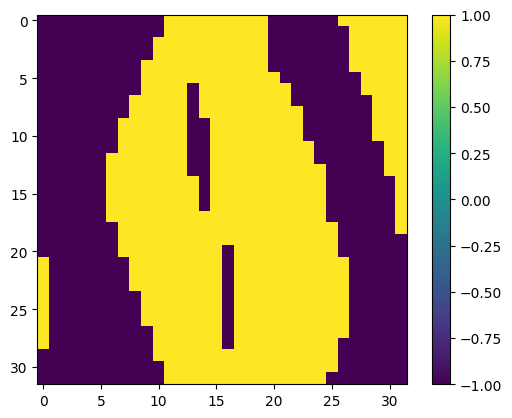

In [10]:
training_data = pyramid[4].detach().cpu().numpy()
training_data.shape
plt.imshow(training_data.squeeze()[0])
plt.colorbar()

In [3]:
def generate_3d_sample(trained_generators_state_dicts, 
                       pyramid, 
                       opt, device, 
                       fixed_noise_maps,
                       gen_start_scale=0, 
                       custom_noise_shape=None,
                       ):
    
    num_scales = len(trained_generators_state_dicts)
    generators = []
    # Load generators from state dicts
    for i in range(num_scales):
        netG = Generator3D(opt).to(device)
        # Load state dict corresponding to scale i (0=finest, N=coarsest)
        # Note: trained_generators was returned finest-to-coarsest
        netG.load_state_dict(trained_generators_state_dicts[i])
        netG.eval() # Set to evaluation mode
        generators.append(netG)

    # Determine starting scale index (N = num_scales - 1)
    start_scale_idx_actual = num_scales - 1 - gen_start_scale

    # Generate initial noise at the starting scale
    if custom_noise_shape:
        # Use custom shape (C, D, H, W)
        noise_shape = (opt.nc_im,) + tuple(custom_noise_shape)
    else:
        # Use shape from the corresponding pyramid level
        noise_shape = pyramid[gen_start_scale].shape[1:] # Get C, D, H, W
    print(f'Generate initial noise at the starting scale with shape: {noise_shape}')
    current_noise = fixed_noise_maps[start_scale_idx_actual] #generate_noise(noise_shape, device)

    current_vols = []
    if gen_start_scale == 0:
        current_vol = torch.zeros((1,) + noise_shape, device=device) # Initial previous output is zero
    else:
        current_vol = pyramid[::-1][gen_start_scale]
    current_vols.append(current_vol.detach().cpu().numpy())


    # Generate through the pyramid from start_scale down to 0 (finest)
    with torch.no_grad():
        for scale_idx in range(start_scale_idx_actual, -1, -1): # Iterate N, N-1,..., start_scale,..., 0
            # Get the generator for this scale (index maps directly: 0=finest, N=coarsest)
            # Need to map scale_idx (N..0) to list index (0..N)
            generator_list_idx = num_scales - 1 - scale_idx
            netG = generators[generator_list_idx]

            # Upsample previous volume
            prev_vol_upsampled = upsample_3d(current_vol, 
                                             scale_factor=opt.scale_factor)
            current_vols.append(prev_vol_upsampled.detach().cpu().numpy())
            
            # # Determine target size for this scale
            # if custom_noise_shape and scale_idx == start_scale_idx_actual:
            #      target_size = noise_shape[-3:]
            # elif scale_idx < num_scales -1 : # Not the coarsest scale being generated
            #      # Infer target size by scaling up from the next coarser scale's pyramid shape
            #      coarser_pyramid_idx = num_scales - 1 - (scale_idx + 1)
            #      coarser_dims = np.array(pyramid[coarser_pyramid_idx].shape[-3:])
            #      target_dims_float = coarser_dims * opt.scale_factor
            #      target_size = tuple(np.ceil(target_dims_float).astype(int))
            #      # Ensure minimum size 1
            #      target_size = tuple(max(1, d) for d in target_size)
            # else: # Coarsest scale being generated (scale_idx == num_scales - 1)
            target_size = noise_shape[-3:] # Use noise shape directly
                 
            print(f'scale_idx = {scale_idx} | target_size = {target_size}')
            print(f'current_noise = {current_noise.shape}')

            # Generate volume for this scale
            current_vol = netG(current_noise, prev_vol_upsampled)
            current_vols.append(current_vol.detach().cpu().numpy())

            # Prepare noise for the next finer scale (if any)
            if scale_idx > 0:
                # print(f"Generating noise for scale {scale_idx-1}")
                # print(f'target size: {target_size}')
                target_size = (1, *target_size)
                current_noise = fixed_noise_maps[scale_idx-1] #generate_noise(target_size, device) # Generate new noise based on current size

    return current_vol

Generate initial noise at the starting scale with shape: torch.Size([1, 6, 11, 11])
scale_idx = 4 | target_size = torch.Size([6, 11, 11])
current_noise = torch.Size([1, 1, 6, 11, 11])
scale_idx = 3 | target_size = torch.Size([6, 11, 11])
current_noise = torch.Size([1, 1, 7, 14, 14])
scale_idx = 2 | target_size = torch.Size([6, 11, 11])
current_noise = torch.Size([1, 1, 9, 18, 18])
scale_idx = 1 | target_size = torch.Size([6, 11, 11])
current_noise = torch.Size([1, 1, 12, 24, 24])
scale_idx = 0 | target_size = torch.Size([6, 11, 11])
current_noise = torch.Size([1, 1, 16, 32, 32])


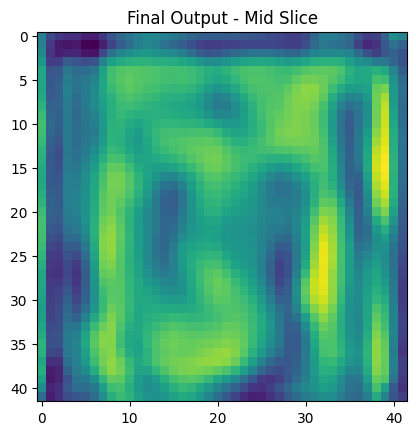

In [4]:

# Assuming `trained_generators_state_dicts`, `pyramid`, `train_opt`, and `device` are defined
dummy = generate_3d_sample(
    trained_generators_state_dicts,
    pyramid,
    train_opt,
    device,
    fixed_noise_maps,
).detach().cpu().numpy().squeeze()

# Show a mid-slice along depth
plt.figure()
plt.imshow(dummy[0])
plt.title('Final Output - Mid Slice')
plt.show()

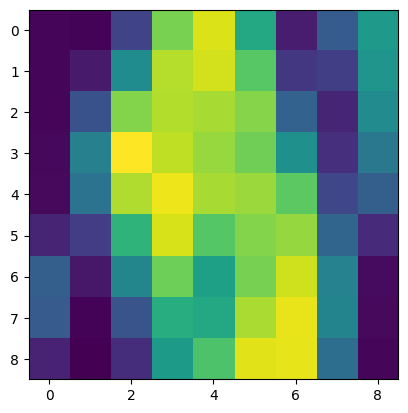

In [426]:
plt.imshow(pyramid[0].detach().cpu().numpy().squeeze()[0])

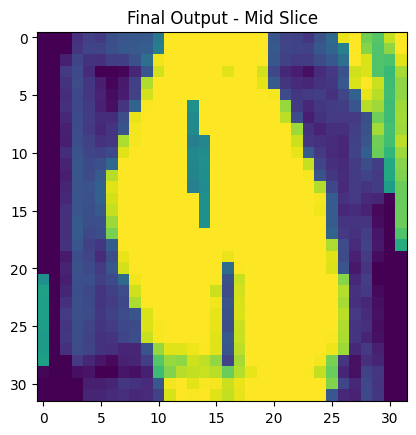

In [ ]:
def generate_3d_sample(trained_generators_state_dicts, pyramid, opt, device, ratio = [0.5, 0.5]):
    ratio = [ratio[0]/sum(ratio), ratio[1]/sum(ratio)]
    num_scales = len(trained_generators_state_dicts)
    generators = []

    # Load generators (finest to coarsest)
    for i in range(num_scales):
        netG = Generator3D(opt).to(device)
        netG.load_state_dict(trained_generators_state_dicts[i])
        netG.eval()
        generators.append(netG)

    # # Reverse generators and pyramid to iterate from coarsest to finest
    # generators = generators
    # pyramid = pyramid

    # Start from coarsest
    start_shape = pyramid[0].shape[1:]  # (C, D, H, W)
    current_vol = torch.zeros((opt.nc_im,) + start_shape, device=device)
    current_vol = pyramid[0]

    with torch.no_grad():
        for netG, real_vol in zip(generators, pyramid):

            # print(real_vol.shape)
            target_size = real_vol.shape[-3:]  # (D, H, W)
            prev_vol_resized = F.interpolate(current_vol, size=target_size, mode='trilinear', align_corners=False)
            noise_this_scale = generate_noise((opt.nc_im,) + target_size, device)
            current_vol = netG(noise_this_scale, prev_vol_resized)
            current_vol = current_vol.clamp(-1, 1)*ratio[0] + real_vol*ratio[1]

    return current_vol

# Assuming `trained_generators_state_dicts`, `pyramid`, `train_opt`, and `device` are defined
dummy = generate_3d_sample(
    trained_generators_state_dicts,
    pyramid,
    train_opt,
    device
).detach().cpu().numpy().squeeze()

# Show a mid-slice along depth
plt.figure()
plt.imshow(dummy[0])
plt.title('Final Output - Mid Slice')
plt.show()

In [15]:
REAL_1 = [] 
for i in range(11):
    dummy = generate_3d_sample(trained_generators_state_dicts,
                                pyramid, # Pass dummy pyramid for shape reference
                                train_opt, # Use options from training
                                device,
                                ratio = [0.7,0.3]).detach().cpu().numpy()
    dummy = (dummy - dummy.min())/(dummy.max() - dummy.min()) * (original.max()-original.min()) + original.min()
    REAL_1.append(dummy)
REAL_1 = np.array(REAL_1).squeeze()

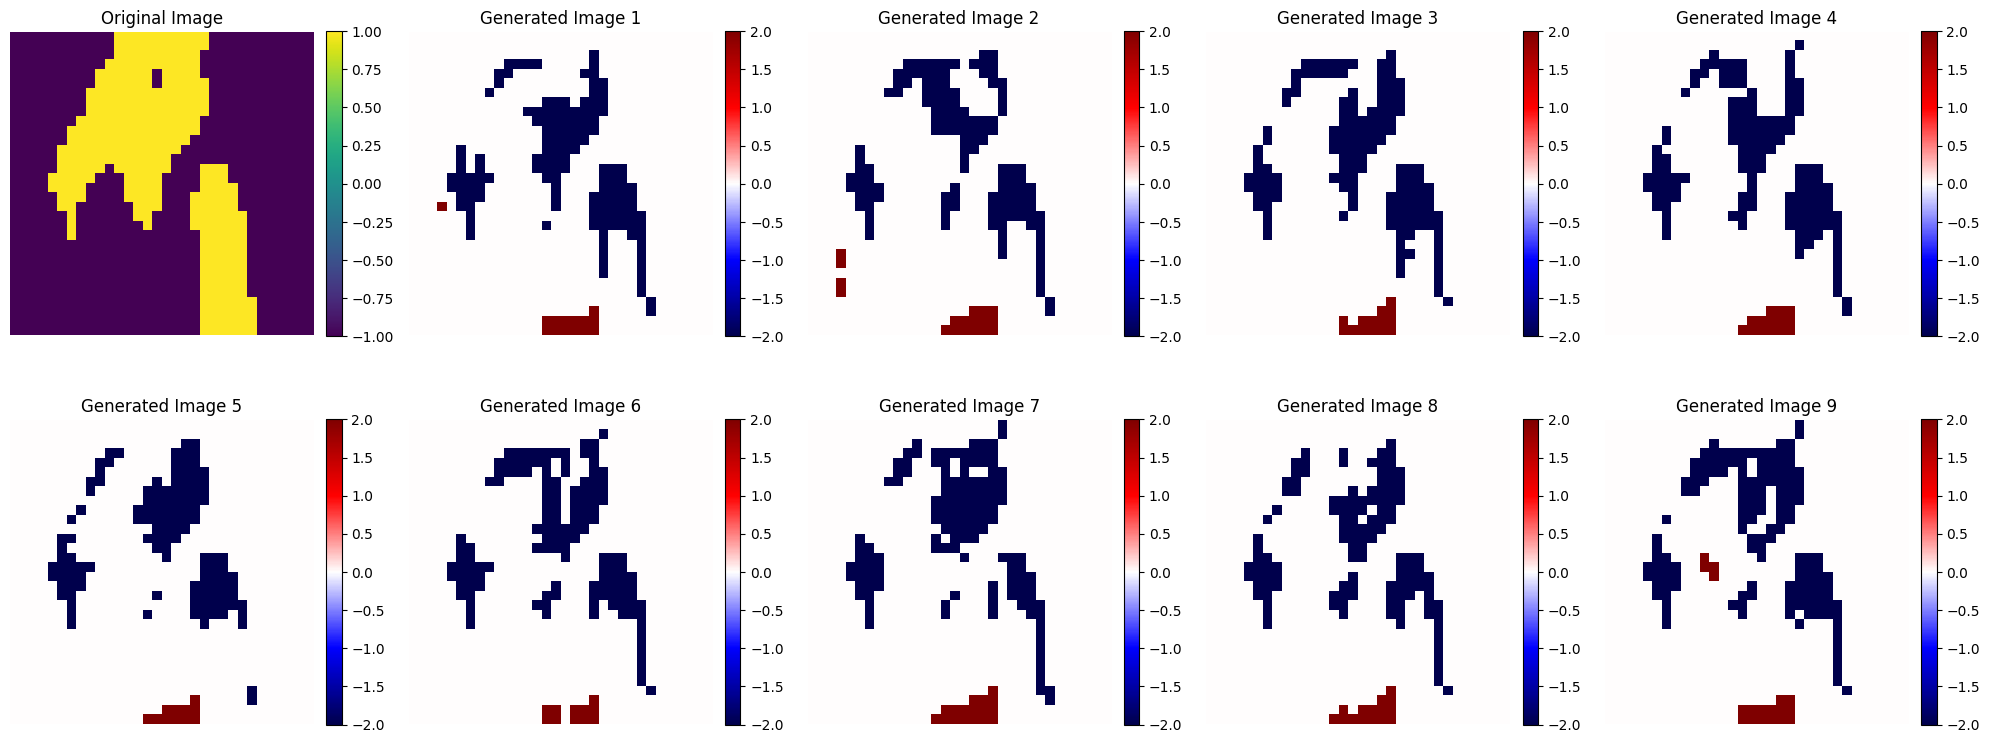

In [13]:

# Parameters
img_width = 4
img_height = 4
num_cols = 5
num_images = 10
layer = 2
num_rows = (num_images + num_cols - 1) // num_cols  # ceiling division for rows

# Create the figure with appropriate size
fig = plt.figure(figsize=(img_width * num_cols, img_height * num_rows))

for i in range(num_images):
    ax = fig.add_subplot(num_rows, num_cols, i + 1)
    
    if i == 0:
        img = original[layer]
        title = 'Original Image'
        im = ax.imshow(img)
    else:
        img = (REAL_1[i] > original.mean())[layer]*2 -1  - original[layer]
        title = f'Generated Image {i}'
        im = ax.imshow(img, cmap = 'seismic')
    
    
    ax.set_title(title)
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

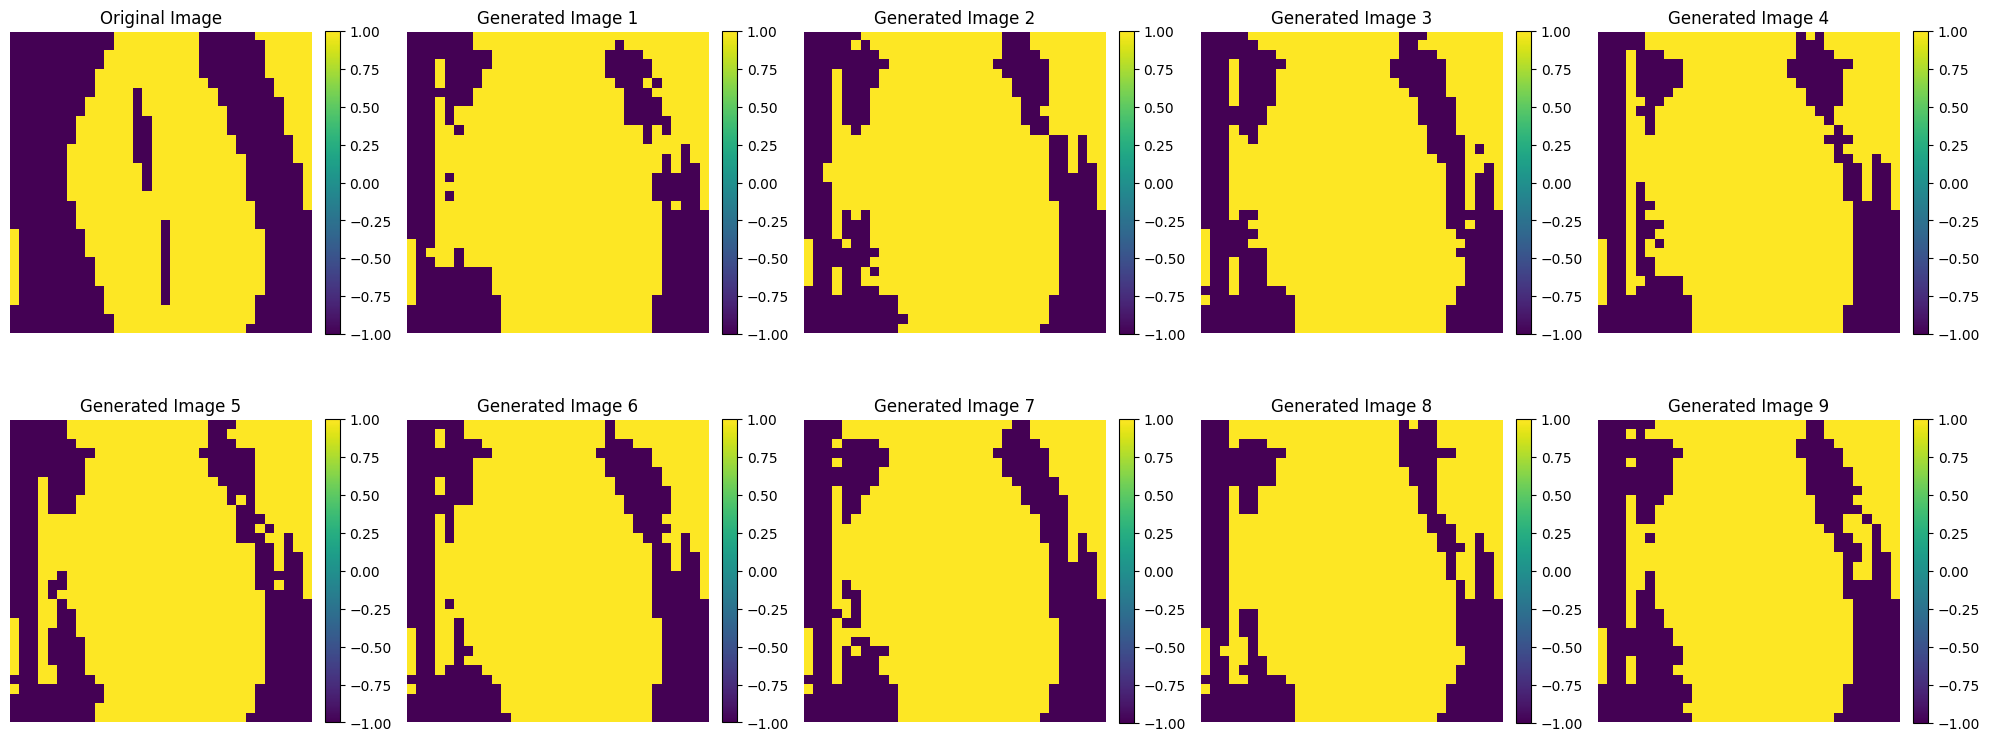

In [16]:

# Parameters
img_width = 4
img_height = 4
num_cols = 5
num_images = 10

layer = 0
num_rows = (num_images + num_cols - 1) // num_cols  # ceiling division for rows

# Create the figure with appropriate size
fig = plt.figure(figsize=(img_width * num_cols, img_height * num_rows))

for i in range(num_images):
    ax = fig.add_subplot(num_rows, num_cols, i + 1)
    
    if i == 0:
        img = original[layer]
        title = 'Original Image'
    else:
        img = (REAL_1[i]> original.mean())[layer]*2 -1 
        title = f'Generated Image {i}'
    
    im = ax.imshow(img)
    
    ax.set_title(title)
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

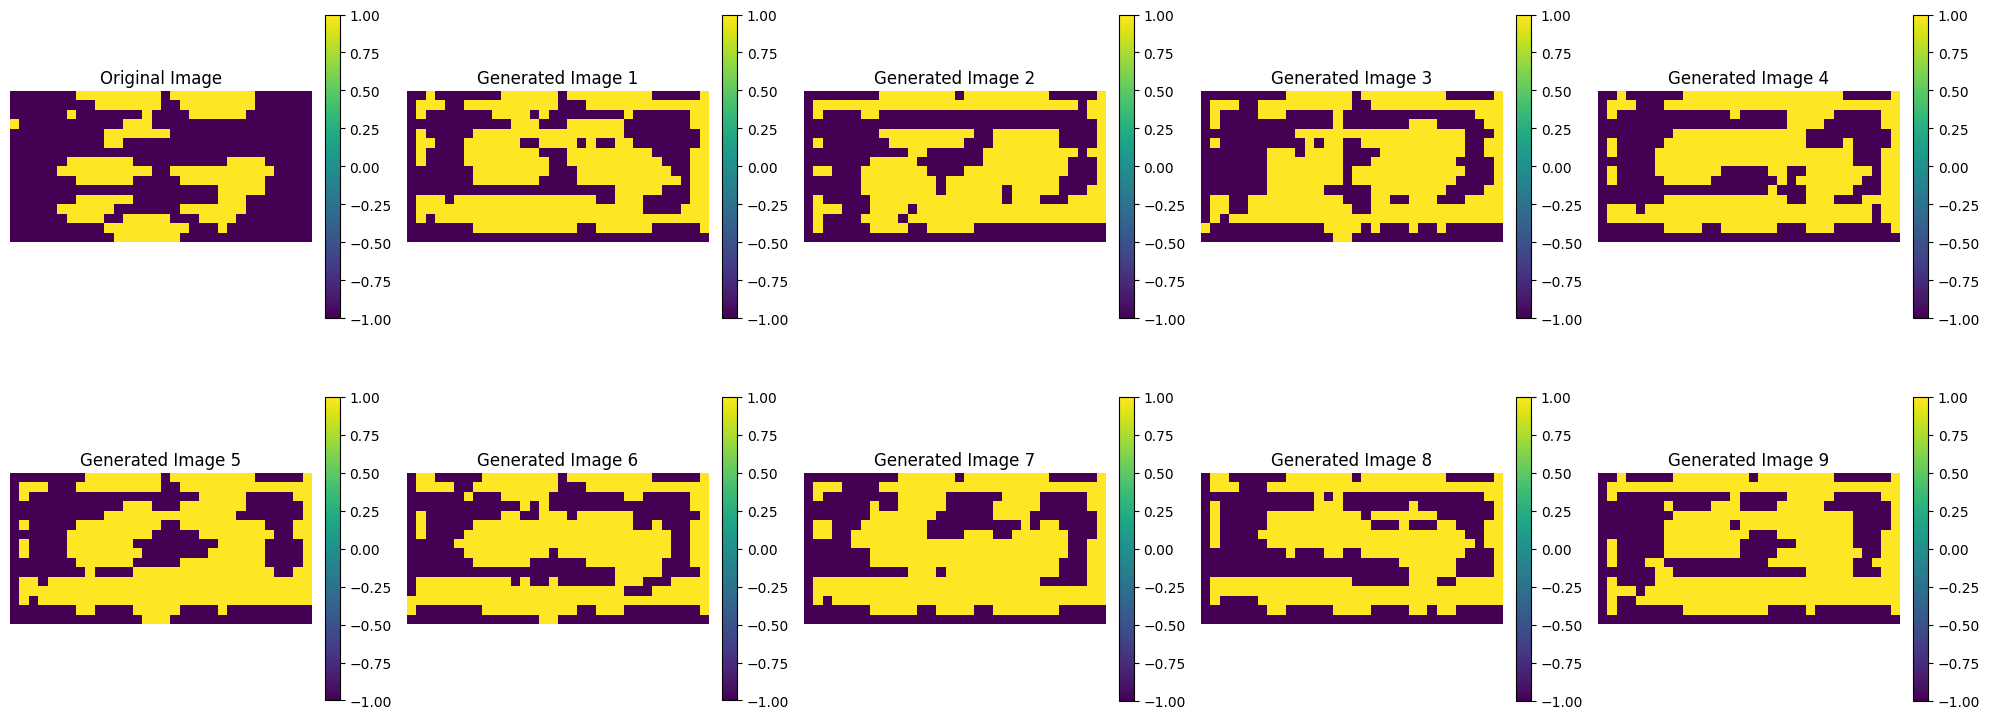

In [524]:

# Parameters
img_width = 4
img_height = 4
num_cols = 5
num_images = 10

layer = 20
num_rows = (num_images + num_cols - 1) // num_cols  # ceiling division for rows

# Create the figure with appropriate size
fig = plt.figure(figsize=(img_width * num_cols, img_height * num_rows))

for i in range(num_images):
    ax = fig.add_subplot(num_rows, num_cols, i + 1)
    
    if i == 0:
        img = original[:,layer]
        title = 'Original Image'
    else:
        img = (REAL_1[i]> original.mean())[:,layer]*2 -1 
        title = f'Generated Image {i}'
    
    im = ax.imshow(img)
    
    ax.set_title(title)
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

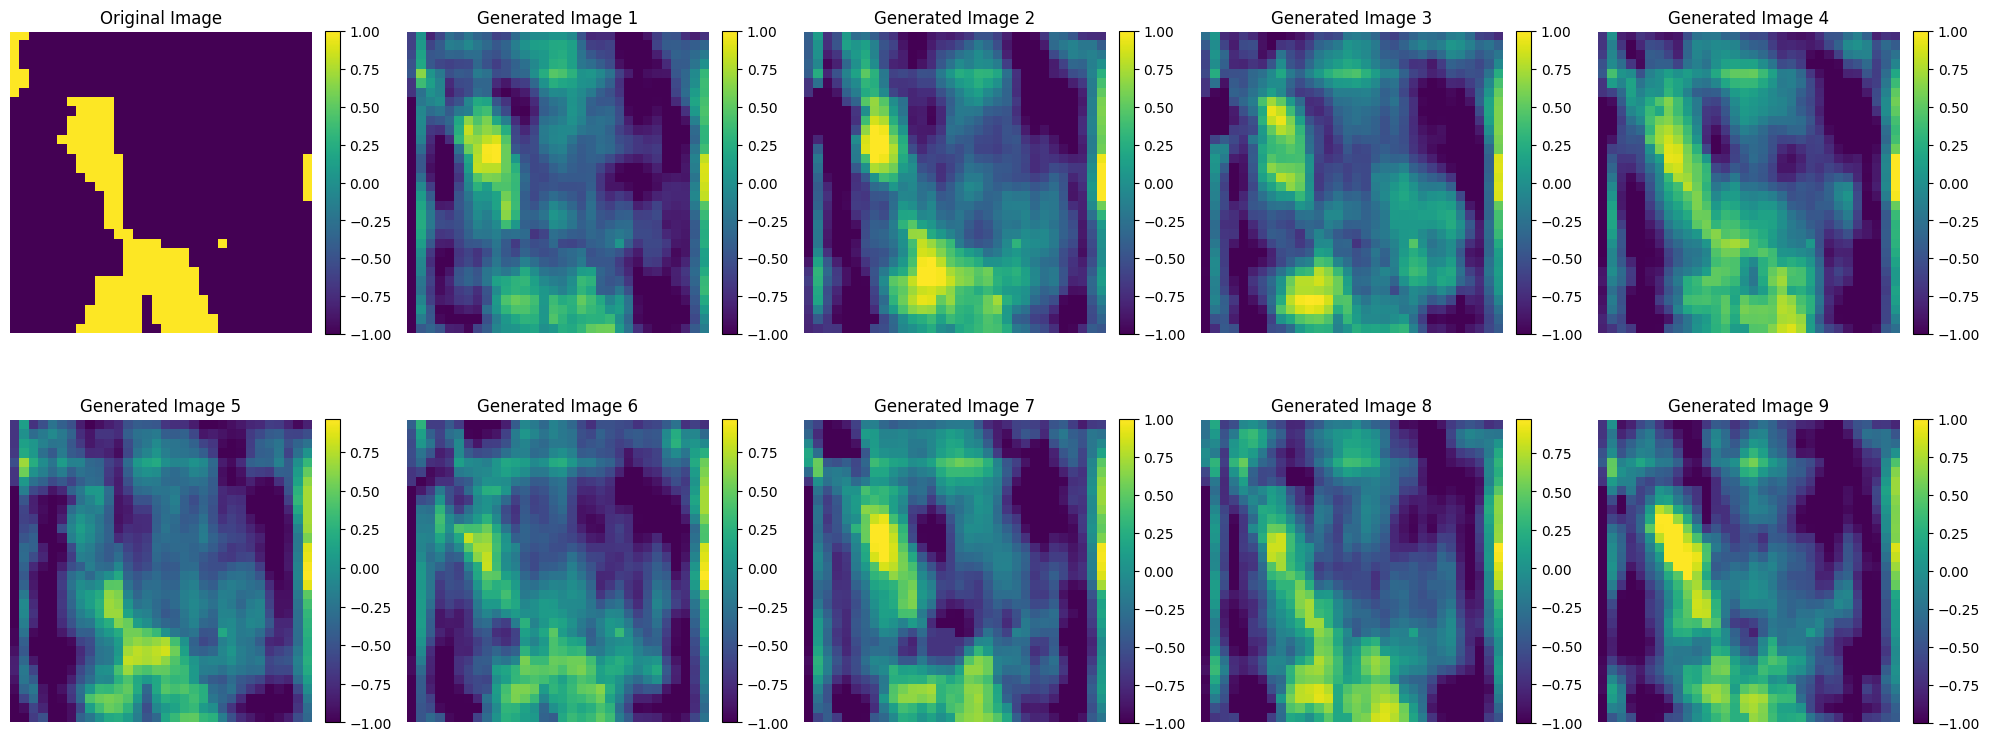

In [ ]:

# Parameters
img_width = 4
img_height = 4
num_cols = 5
num_images = 10
num_rows = (num_images + num_cols - 1) // num_cols  # ceiling division for rows

# Create the figure with appropriate size
fig = plt.figure(figsize=(img_width * num_cols, img_height * num_rows))

for i in range(num_images):
    ax = fig.add_subplot(num_rows, num_cols, i + 1)
    
    if i == 0:
        img = original[5]
        title = 'Original Image'
    else:
        img = (REAL_1[i] > )[5]
        title = f'Generated Image {i}'
    
    im = ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (32,31) (32,32) 

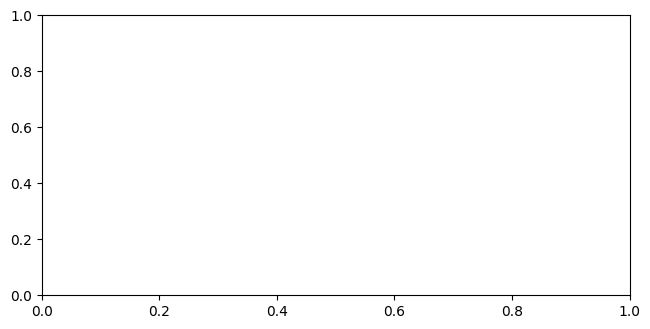

In [471]:
img_width = 4
img_height = 4
num_of_image_in_a_row = 5

for i in range(len(REAL_1)):
    if i == 0:
        plt.figure(figsize = (img_width*len(REAL_1),img_height*len(REAL_1)//5))
    plt.subplot(len(REAL_1)//num_of_image_in_a_row, num_of_image_in_a_row,i+1)
    plt.imshow(REAL_1[i].mean(0)[:,1:]- original.mean(0), cmap = plt.cm.seismic)
    plt.colorbar()

In [ ]:
plt.imshow(REAL_1[1].mean(0)-)

In [ ]:
plt.imshow(REAL_1[0].mean(0))

In [ ]:
REAL_1 = [] 
for i in range(500):
    dummy = generate_3d_sample(trained_generators_state_dicts,
                                pyramid, # Pass dummy pyramid for shape reference
                                train_opt, # Use options from training
                                device,
                                gen_start_scale=0).detach().cpu().numpy()
    dummy = (dummy - dummy.min())/(dummy.max() - dummy.min()) * (original.max()-original.min()) + original.min()
    REAL_1.append(dummy)
REAL_1 = np.array(REAL_1).squeeze()

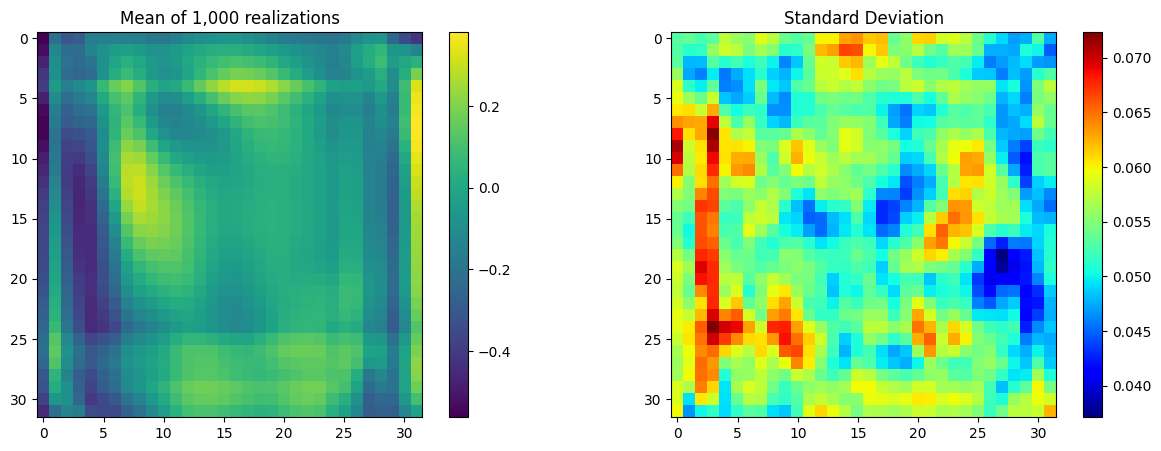

In [18]:
plt.figure(figsize=(15,5)   )
plt.subplot(1,2,1)
plt.title("Mean of 1,000 realizations")
plt.imshow(REAL_1.mean(1).mean(0), cmap='viridis')
plt.colorbar()
plt.subplot(1,2,2)
plt.title("Standard Deviation")
plt.imshow(REAL_1.mean(1).std(0), cmap='jet')
plt.colorbar()